In [14]:
import pandas as pd
import numpy as np
import nba_api

# Data Collection

In [15]:
from nba_api.stats.endpoints import leaguedashplayerstats
from nba_api.stats.endpoints import leaguedashptdefend

play_basic = leaguedashplayerstats.LeagueDashPlayerStats(per_mode_detailed="PerGame", season='2022-23').get_data_frames()[0]
play_advanced = leaguedashplayerstats.LeagueDashPlayerStats(measure_type_detailed_defense="Advanced", per_mode_detailed="PerGame", season='2022-23').get_data_frames()[0]
play_defense = leaguedashplayerstats.LeagueDashPlayerStats(measure_type_detailed_defense="Defense", per_mode_detailed="PerGame", season='2022-23').get_data_frames()[0]
play_opponent = leaguedashptdefend.LeagueDashPtDefend(defense_category="Overall", season='2022-23').get_data_frames()[0]

In [16]:
play_basic.shape

(539, 66)

In [17]:
# Storing Required Information from players

player_id = list(set(play_basic["PLAYER_ID"]))
player_dict = {}

for p in player_id:
    # Field Goal %
    fg_pct = play_basic[play_basic["PLAYER_ID"] == p]["FG_PCT"].values[0]
    # Assist to turnover ratio
    ast_to = play_advanced[play_advanced["PLAYER_ID"] == p]["AST_TO"].values[0]
    # Offensive Rebound %
    oreb = play_advanced[play_advanced["PLAYER_ID"] == p]["OREB_PCT"].values[0]
    # Defensive Rebound %
    dreb = play_advanced[play_advanced["PLAYER_ID"] == p]["DREB_PCT"].values[0]
    # Steal %
    stl = play_defense[play_defense["PLAYER_ID"] == p]["PCT_STL"].values[0]
    # Opponent Miss %
    if len(play_opponent[play_opponent["CLOSE_DEF_PERSON_ID"] == p]["D_FG_PCT"]) > 0:
        opp_miss = 1-play_opponent[play_opponent["CLOSE_DEF_PERSON_ID"] == p]["D_FG_PCT"].values[0]
        player_dict[p] = [fg_pct, ast_to, oreb, dreb, stl, round(opp_miss, 2)]
    else:
        player_dict[p] = [fg_pct, ast_to, oreb, dreb, stl, 0]

In [41]:
# Storing all lineups
from nba_api.stats.endpoints import leaguedashlineups

lineups_basic = leaguedashlineups.LeagueDashLineups(per_mode_detailed="PerGame", season='2022-23').get_data_frames()[0]
lineups_advanced = leaguedashlineups.LeagueDashLineups(per_mode_detailed="PerGame", measure_type_detailed_defense="Advanced", season='2022-23').get_data_frames()[0]
lineups_opponent = leaguedashlineups.LeagueDashLineups(per_mode_detailed="PerGame", measure_type_detailed_defense="Opponent", season='2022-23').get_data_frames()[0]

# Filter out lineups with less than 5 games played and irrelevant stats
lineups_basic = lineups_basic[(lineups_basic["GP"] >= 5) & (lineups_basic["MIN"] >= 2)].reset_index(drop=True)
lineups_basic = lineups_basic[["GROUP_ID", "GROUP_NAME", "TEAM_ID", "TEAM_ABBREVIATION", "GP", "MIN", "FG_PCT", "STL"]]
lineups_advanced = lineups_advanced[lineups_advanced["GP"] >= 5].reset_index(drop=True)
lineups_advanced = lineups_advanced[["GROUP_ID", "GROUP_NAME", "TEAM_ID", "TEAM_ABBREVIATION", "GP", "AST_TO", "OREB_PCT", "DREB_PCT"]]
lineups_opponent = lineups_opponent[lineups_opponent["GP"] >= 5].reset_index(drop=True)
lineups_opponent = lineups_opponent[["GROUP_ID", "GROUP_NAME", "TEAM_ID", "TEAM_ABBREVIATION", "GP", "OPP_FG_PCT"]]
lineups_opponent["OPP_FG_PCT"] = 1 - lineups_opponent["OPP_FG_PCT"]

lineups = pd.merge(lineups_basic, lineups_advanced, on=["GROUP_ID", "GROUP_NAME", "TEAM_ID", "TEAM_ABBREVIATION", "GP"])
lineups = pd.merge(lineups, lineups_opponent, on=["GROUP_ID", "GROUP_NAME", "TEAM_ID", "TEAM_ABBREVIATION", "GP"])
 
# lineups = lineups[["GROUP_ID", "GROUP_NAME", "TEAM_ID", "TEAM_ABBREVIATION", "GP", "MIN"]].sort_values(["GP", "MIN"], ascending=False).reset_index(drop=True)

In [42]:
# Normalise Columns
lineups["FG_PCT"] = (lineups["FG_PCT"] - lineups["FG_PCT"].mean())/lineups["FG_PCT"].std()
lineups["STL"] = (lineups["STL"] - lineups["STL"].mean())/lineups["STL"].std()
lineups["OREB_PCT"] = (lineups["OREB_PCT"] - lineups["OREB_PCT"].mean())/lineups["OREB_PCT"].std()
lineups["DREB_PCT"] = (lineups["DREB_PCT"] - lineups["DREB_PCT"].mean())/lineups["DREB_PCT"].std()
lineups["AST_TO"] = (lineups["AST_TO"] - lineups["AST_TO"].mean())/lineups["AST_TO"].std()
lineups["OPP_FG_PCT"] = (lineups["OPP_FG_PCT"] - lineups["OPP_FG_PCT"].mean())/lineups["OPP_FG_PCT"].std()

In [43]:
lineups.shape

(1219, 12)

In [44]:
# Pair Players with their respective lineup

lineup_ls = lineups["GROUP_ID"].str.split("-").str[1:6]
fg_tups = []
ast_to_tups = []
oreb_tups = []
dreb_tups = []
stl_tups = []
opp_miss_tups = []

num_lineups = lineups.groupby("TEAM_ABBREVIATION").count()

for p in player_id:
    j = 0
    play_index = []
    
    # Find all lineups involving the player
    for ls in lineup_ls:
        if str(p) in ls:
            play_index.append(j)
        j += 1
    
    if len(play_index) > 0:
        df = lineups.loc[play_index]
        df_grouped = df.groupby("TEAM_ABBREVIATION").count()
        df_team = list(df_grouped.index)
        
        # Giving more weight to players involved in more important lineups
        for t in df_team:
            # Calculating average minute of lineups for team
            avg_lineup_min = np.mean(lineups[lineups["TEAM_ABBREVIATION"] == t].MIN)
            # Players who got traded mid season -> Filtering different teams
            team_df = df[df["TEAM_ABBREVIATION"] == t].reset_index(drop=True)
            lineup_min = list(team_df["MIN"])
            
            i = 0
            for m in lineup_min:
                # (Weight * minutes of lineup)/(average lineups minutes of the team)
                group_id = team_df.iloc[i]["GROUP_ID"]
                # Also need to adjust for stats from the lineup
                fg_norm = 1 + team_df.iloc[i]["FG_PCT"]
                ast_norm = 1 + team_df.iloc[i]["AST_TO"]
                oreb_norm = 1 + team_df.iloc[i]["OREB_PCT"]
                dreb_norm = 1 + team_df.iloc[i]["DREB_PCT"]
                stl_norm = 1 + team_df.iloc[i]["STL"]
                opp_norm = 1 + team_df.iloc[i]["OPP_FG_PCT"]
                # Apply to all other stats
                fg_tups.append((p, group_id, player_dict[p][0] * m/avg_lineup_min * fg_norm))
                ast_to_tups.append((p, group_id, player_dict[p][1] * m/avg_lineup_min * ast_norm))
                oreb_tups.append((p, group_id, player_dict[p][2] * m/avg_lineup_min * oreb_norm))
                dreb_tups.append((p, group_id, player_dict[p][3] * m/avg_lineup_min * dreb_norm))
                stl_tups.append((p, group_id, player_dict[p][4] * m/avg_lineup_min * stl_norm))
                opp_miss_tups.append((p, group_id, player_dict[p][5] * m/avg_lineup_min * opp_norm))
                i += 1

# Building the Network

From the data-set, a bipartite graph is constructed where nodes are either players or fiveman units that play together. Weighted edges are drawn between player nodes and line-up
nodes where the weight is one of the six metrics defined in 4.2 as providing insight into how
effective a player is. As a result, each of these weighting functions results in a different
bipartite graph, all with the same edge-set but with different weights. 


In [45]:
import networkx as nx
import matplotlib.pyplot as plt

## FG%

In [46]:
team_abbrev = list(set(lineups_basic["TEAM_ABBREVIATION"]))
all_pg_dicts_fg = []
all_eigen_dicts_fg = []

i = 0
for t in team_abbrev:
    # Build Network by Team
    t_lineups = list(lineups_basic[lineups_basic["TEAM_ABBREVIATION"] == t]["GROUP_ID"])
    temp_tup = []
    
    for tup in fg_tups:
        l = tup[1] # Lineup
        if l in t_lineups:
            temp_tup.append(tup)

    tempG = nx.Graph()
    tempG.add_weighted_edges_from(temp_tup)
    
    centrality = nx.eigenvector_centrality(tempG, weight='weight')
    pagerank = nx.pagerank(tempG)
    
    eigen_dict = {}
    page_dict = {}
    
    for p in centrality:
        if p in player_id:
            name = play_basic[play_basic["PLAYER_ID"] == p]["PLAYER_NAME"].values[0]
            page_dict[name] = pagerank[p]
            eigen_dict[name] = centrality[p]
    
    sorted_page_dict = sorted(page_dict.items(), key=lambda x: x[1], reverse=True)
    sorted_eigen_dict = sorted(eigen_dict.items(), key=lambda x: x[1], reverse=True)
    
    all_pg_dicts_fg.append(sorted_page_dict)
    all_eigen_dicts_fg.append(sorted_eigen_dict)

In [47]:
fg_pg_result = {}
fg_eigen_result = {}

for d in all_pg_dicts_fg:
    fg_pg_result.update(d)
    
for e in all_eigen_dicts_fg:
    fg_eigen_result.update(e)

In [48]:
fg_pg_result = sorted(fg_pg_result.items(), key=lambda x: x[1], reverse=True)
fg_pg_result[:10] 

[('Ivica Zubac', 0.09213283622907464),
 ('Nic Claxton', 0.09161950362586392),
 ('Bam Adebayo', 0.08837301041010039),
 ('Jalen Williams', 0.08245527187290475),
 ('Shai Gilgeous-Alexander', 0.08239000995461263),
 ('Deandre Ayton', 0.08101343636573861),
 ('Jarrett Allen', 0.08010023512034709),
 ('Luka Doncic', 0.07934849618779657),
 ('Jalen Duren', 0.07927428672417725),
 ('Nikola Jokic', 0.07921992786644778)]

In [49]:
fg_eigen_result = sorted(fg_eigen_result.items(), key=lambda x: x[1], reverse=True)
fg_eigen_result[:10]

[('Ivica Zubac', 0.48334669627788035),
 ('Deandre Ayton', 0.44285594870809597),
 ('Jalen Duren', 0.42977828690645803),
 ('Nic Claxton', 0.4260408678178495),
 ('Bam Adebayo', 0.42223588433693293),
 ('Anthony Davis', 0.3979830658865668),
 ('Rudy Gobert', 0.39682202314833526),
 ('Nikola Jokic', 0.3938978276518752),
 ('Luka Doncic', 0.39173694570342676),
 ('Alperen Sengun', 0.3862747212710394)]

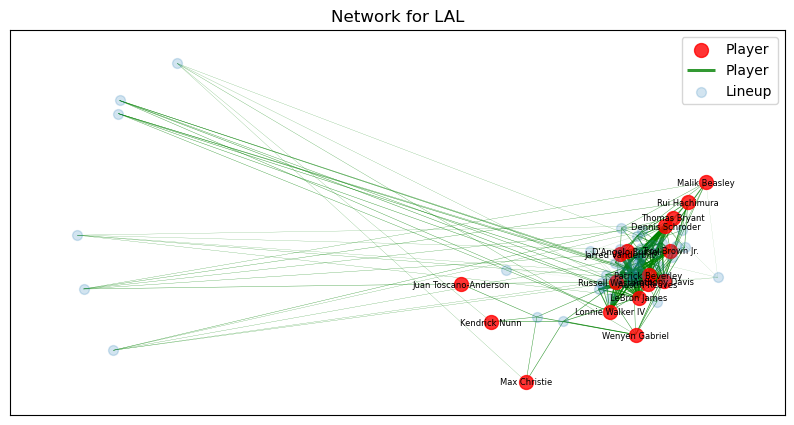

In [51]:
plt.figure(figsize=(10, 5))
pid_ls = []
lid_ls = []

for n in list(tempG.nodes()):
    if type(n) == int:
        pid_ls.append(n)
    else:
        lid_ls.append(n)

name_id_dict = {}

for p in pid_ls:
    name = play_basic[play_basic["PLAYER_ID"] == p]["PLAYER_NAME"].values[0]
    name_id_dict[p] = name

edge_weight = list(nx.get_edge_attributes(tempG,'weight').values())

pos = nx.spring_layout(tempG)
nx.draw_networkx(tempG, pos, width=edge_weight, nodelist=pid_ls, node_color='r', node_size=100,
                 label='Player', with_labels=False, edge_color='g', alpha=0.8)
nx.draw_networkx_nodes(tempG, pos, nodelist=lid_ls, node_size=50, alpha=0.2, label="Lineup")
nx.draw_networkx_labels(tempG, pos, labels=name_id_dict, verticalalignment = "center_baseline", font_size=6,
                        horizontalalignment="center")

plt.title("Network for {}".format(t))
plt.legend()
plt.show()

## AST TO

### Network by Team

In [52]:
all_pg_dicts_ast_to = []
all_eigen_dicts_ast_to = []

for t in team_abbrev:
    # Build Network by Team
    t_lineups = list(lineups_basic[lineups_basic["TEAM_ABBREVIATION"] == t]["GROUP_ID"])
    temp_tup = []
    
    for tup in ast_to_tups:
        l = tup[1] # Lineup
        if l in t_lineups:
            temp_tup.append(tup)

    tempG = nx.Graph()
    tempG.add_weighted_edges_from(temp_tup)
    centrality = nx.eigenvector_centrality(tempG, weight='weight', max_iter=500)
    pagerank = nx.pagerank(tempG)
    
    eigen_dict = {}
    page_dict = {}
    
    for p in centrality:
        if p in player_id:
            name = play_basic[play_basic["PLAYER_ID"] == p]["PLAYER_NAME"].values[0]
            page_dict[name] = pagerank[p]
            eigen_dict[name] = centrality[p]
    
    sorted_page_dict = sorted(page_dict.items(), key=lambda x: x[1], reverse=True)
    sorted_eigen_dict = sorted(eigen_dict.items(), key=lambda x: x[1], reverse=True)
    
    all_pg_dicts_ast_to.append(sorted_page_dict)
    all_eigen_dicts_ast_to.append(sorted_eigen_dict)

In [55]:
astto_pg_result = {}
astto_eigen_result = {}

for d in all_pg_dicts_ast_to:
    astto_pg_result.update(d)
    
for e in all_eigen_dicts_ast_to:
    astto_eigen_result.update(e)

In [56]:
astto_pg_result = sorted(astto_pg_result.items(), key=lambda x: x[1], reverse=True)
astto_pg_result[:10]

[('Tyus Jones', 0.13478734450053093),
 ('Chris Paul', 0.12214298279991052),
 ('Monte Morris', 0.11665549715898468),
 ('Tyrese Haliburton', 0.11513324209372564),
 ('Fred VanVleet', 0.11330379312713085),
 ('Dejounte Murray', 0.10007887128139226),
 ('Tre Jones', 0.0960412060898714),
 ('Jimmy Butler', 0.09593637606587808),
 ('Kevon Looney', 0.09052359774218706),
 ('Darius Garland', 0.08899064869751522)]

In [57]:
astto_eigen_result = sorted(astto_eigen_result.items(), key=lambda x: x[1], reverse=True)
astto_eigen_result[:10]

[('Tyus Jones', 0.6416451897388082),
 ('Monte Morris', 0.625032887045179),
 ('Chris Paul', 0.6167251914838368),
 ('Tyrese Haliburton', 0.5908103495412398),
 ('Tre Jones', 0.5863192218582788),
 ('Kevon Looney', 0.5525846021077013),
 ('Dejounte Murray', 0.5289149185311848),
 ('Mike Conley', 0.5013601222858297),
 ('Jimmy Butler', 0.4910611284037033),
 ('Patrick Beverley', 0.4579794021868897)]

## OREB%

In [58]:
all_pg_dicts_oreb = []
all_eigen_dicts_oreb = []

for t in team_abbrev:
    # Build Network by Team
    t_lineups = list(lineups_basic[lineups_basic["TEAM_ABBREVIATION"] == t]["GROUP_ID"])
    temp_tup = []
    
    for tup in oreb_tups:
        l = tup[1] # Lineup
        if l in t_lineups:
            temp_tup.append(tup)

    tempG = nx.Graph()
    tempG.add_weighted_edges_from(temp_tup)
    centrality = nx.eigenvector_centrality(tempG, weight='weight', max_iter=500)
    pagerank = nx.pagerank(tempG, max_iter=500)
    
    eigen_dict = {}
    page_dict = {}
    
    for p in centrality:
        if p in player_id:
            name = play_basic[play_basic["PLAYER_ID"] == p]["PLAYER_NAME"].values[0]
            page_dict[name] = pagerank[p]
            eigen_dict[name] = centrality[p]
    
    sorted_page_dict = sorted(page_dict.items(), key=lambda x: x[1], reverse=True)
    sorted_eigen_dict = sorted(eigen_dict.items(), key=lambda x: x[1], reverse=True)
    
    all_pg_dicts_oreb.append(sorted_page_dict)
    all_eigen_dicts_oreb.append(sorted_eigen_dict)

In [59]:
oreb_pg_result = {}
oreb_eigen_result = {}

for d in all_pg_dicts_oreb:
    oreb_pg_result.update(d)
    
for e in all_eigen_dicts_oreb:
    oreb_eigen_result.update(e)

In [60]:
oreb_pg_result = sorted(oreb_pg_result.items(), key=lambda x: x[1], reverse=True)
oreb_pg_result[:10]

[('Nikola Vucevic', 0.19427703928861248),
 ('Ivica Zubac', 0.17084944746318728),
 ('Rudy Gobert', 0.16680258100322146),
 ('Jalen Duren', 0.15814498112517264),
 ('Anthony Davis', 0.15019526751690265),
 ('Jarrett Allen', 0.14633060874078113),
 ('Kevon Looney', 0.14361590998585413),
 ('Nic Claxton', 0.1429806421577348),
 ('Dwight Powell', 0.13438818990790502),
 ('Walker Kessler', 0.13346061241590126)]

In [61]:
oreb_eigen_result = sorted(oreb_eigen_result.items(), key=lambda x: x[1], reverse=True)
oreb_eigen_result[:10]

[("Day'Ron Sharpe", 0.687013744254695),
 ('Clint Capela', 0.6784583292806476),
 ('Steven Adams', 0.6735935202745921),
 ('Kevon Looney', 0.6686171623106674),
 ('Mitchell Robinson', 0.6649557289794304),
 ('Paul Reed', 0.6634560022852546),
 ('Ivica Zubac', 0.6613725849117816),
 ('Andre Drummond', 0.6587872957352748),
 ('Rudy Gobert', 0.6545494065283265),
 ('Jalen Duren', 0.6507925782442626)]

## DREB%

In [62]:
all_pg_dicts_dreb = []
all_eigen_dicts_dreb = []

for t in team_abbrev:
    # Build Network by Team
    t_lineups = list(lineups_basic[lineups_basic["TEAM_ABBREVIATION"] == t]["GROUP_ID"])
    temp_tup = []
    
    for tup in dreb_tups:
        l = tup[1] # Lineup
        if l in t_lineups:
            temp_tup.append(tup)

    tempG = nx.Graph()
    tempG.add_weighted_edges_from(temp_tup)
    centrality = nx.eigenvector_centrality(tempG, weight='weight', max_iter=500)
    pagerank = nx.pagerank(tempG, max_iter=500)
    
    eigen_dict = {}
    page_dict = {}
    
    for p in centrality:
        if p in player_id:
            name = play_basic[play_basic["PLAYER_ID"] == p]["PLAYER_NAME"].values[0]
            page_dict[name] = pagerank[p]
            eigen_dict[name] = centrality[p]
    
    sorted_page_dict = sorted(page_dict.items(), key=lambda x: x[1], reverse=True)
    sorted_eigen_dict = sorted(eigen_dict.items(), key=lambda x: x[1], reverse=True)
    
    all_pg_dicts_dreb.append(sorted_page_dict)
    all_eigen_dicts_dreb.append(sorted_eigen_dict)

In [63]:
dreb_pg_result = {}
dreb_eigen_result = {}

for d in all_pg_dicts_dreb:
    dreb_pg_result.update(d)
    
for e in all_eigen_dicts_dreb:
    dreb_eigen_result.update(e)

In [64]:
dreb_pg_result = sorted(dreb_pg_result.items(), key=lambda x: x[1], reverse=True)
dreb_pg_result[:10]

[('Nikola Vucevic', 0.11962618364595395),
 ('Domantas Sabonis', 0.11668145430328365),
 ('Luka Doncic', 0.11469758757002184),
 ('Bam Adebayo', 0.11259286700977801),
 ('Nikola Jokic', 0.1125074858243346),
 ('Ivica Zubac', 0.1097496783484317),
 ('Anthony Davis', 0.10866719503371378),
 ('Josh Giddey', 0.10693557493962413),
 ('Rudy Gobert', 0.10592912150059984),
 ('Nic Claxton', 0.1050182274661963)]

In [65]:
dreb_eigen_result = sorted(dreb_eigen_result.items(), key=lambda x: x[1], reverse=True)[:10]
dreb_eigen_result[:10]

[('Jonas Valanciunas', 0.5972520995499006),
 ('Nikola Vucevic', 0.5937855766732363),
 ('Domantas Sabonis', 0.5860179259169308),
 ('Nikola Jokic', 0.580308295073044),
 ('Deandre Ayton', 0.5658915508270485),
 ('Rudy Gobert', 0.5657478665317655),
 ('Ivica Zubac', 0.5431532294149878),
 ('Julius Randle', 0.5334010042397702),
 ('Clint Capela', 0.5306395237516989),
 ('Luka Doncic', 0.5281602578830608)]

## STL

In [66]:
all_pg_dicts_stl = []
all_eigen_dicts_stl = []

for t in team_abbrev:
    # Build Network by Team
    t_lineups = list(lineups_basic[lineups_basic["TEAM_ABBREVIATION"] == t]["GROUP_ID"])
    temp_tup = []
    
    for tup in stl_tups:
        l = tup[1] # Lineup
        if l in t_lineups:
            temp_tup.append(tup)

    tempG = nx.Graph()
    tempG.add_weighted_edges_from(temp_tup)
    centrality = nx.eigenvector_centrality(tempG, weight='weight', max_iter=500)
    pagerank = nx.pagerank(tempG, max_iter=500)
    
    eigen_dict = {}
    page_dict = {}
    
    for p in centrality:
        if p in player_id:
            name = play_basic[play_basic["PLAYER_ID"] == p]["PLAYER_NAME"].values[0]
            page_dict[name] = pagerank[p]
            eigen_dict[name] = centrality[p]
    
    sorted_page_dict = sorted(page_dict.items(), key=lambda x: x[1], reverse=True)
    sorted_eigen_dict = sorted(eigen_dict.items(), key=lambda x: x[1], reverse=True)
    
    all_pg_dicts_stl.append(sorted_page_dict)
    all_eigen_dicts_stl.append(sorted_eigen_dict)

In [67]:
stl_pg_result = {}
stl_eigen_result = {}

for d in all_pg_dicts_stl:
    stl_pg_result.update(d)
    
for e in all_eigen_dicts_stl:
    stl_eigen_result.update(e)

In [68]:
stl_pg_result = sorted(stl_pg_result.items(), key=lambda x: x[1], reverse=True)
stl_pg_result[:10]

[("De'Anthony Melton", 0.10394484320126998),
 ('Luka Doncic', 0.09889020988465955),
 ('O.G. Anunoby', 0.09469106587717602),
 ('Donovan Mitchell', 0.09378613171523131),
 ('Anthony Edwards', 0.09259310487595535),
 ('Chris Paul', 0.092482521827325),
 ('Dejounte Murray', 0.09219158437867968),
 ('Shai Gilgeous-Alexander', 0.09047807535352627),
 ('Kentavious Caldwell-Pope', 0.0897292695362099),
 ('Jrue Holiday', 0.0884162850586929)]

In [69]:
stl_eigen_result = sorted(stl_eigen_result.items(), key=lambda x: x[1], reverse=True)
stl_eigen_result[:10]

[('Chris Paul', 0.5119476940609863),
 ('Herbert Jones', 0.5111897729061279),
 ("De'Anthony Melton", 0.5087649179164822),
 ('Jimmy Butler', 0.48110522962148533),
 ('Luka Doncic', 0.4778582514727328),
 ('Marcus Smart', 0.4764839033909725),
 ('Markelle Fultz', 0.47392737130693535),
 ('Alex Caruso', 0.4658403540574591),
 ('Dejounte Murray', 0.46025534994372447),
 ('Donovan Mitchell', 0.45140440372573987)]

## Opponent Miss FG%

In [70]:
all_pg_dicts_opp_miss = []
all_eigen_dicts_opp_miss = []

for t in team_abbrev:
    # Build Network by Team
    t_lineups = list(lineups_basic[lineups_basic["TEAM_ABBREVIATION"] == t]["GROUP_ID"])
    temp_tup = []
    
    for tup in opp_miss_tups:
        l = tup[1] # Lineup
        if l in t_lineups:
            temp_tup.append(tup)

    tempG = nx.Graph()
    tempG.add_weighted_edges_from(temp_tup)
    centrality = nx.eigenvector_centrality(tempG, weight='weight', max_iter=500)
    pagerank = nx.pagerank(tempG, max_iter=500, alpha=0.71)
    
    eigen_dict = {}
    page_dict = {}
    
    for p in centrality:
        if p in player_id:
            name = play_basic[play_basic["PLAYER_ID"] == p]["PLAYER_NAME"].values[0]
            page_dict[name] = pagerank[p]
            eigen_dict[name] = centrality[p]
    
    sorted_page_dict = sorted(page_dict.items(), key=lambda x: x[1], reverse=True)
    sorted_eigen_dict = sorted(eigen_dict.items(), key=lambda x: x[1], reverse=True)
    
    all_pg_dicts_opp_miss.append(sorted_page_dict)
    all_eigen_dicts_opp_miss.append(sorted_eigen_dict)

In [71]:
opp_miss_pg_result = {}
opp_miss_eigen_result = {}

for d in all_pg_dicts_opp_miss:
    opp_miss_pg_result.update(d)
    
for e in all_eigen_dicts_opp_miss:
    opp_miss_eigen_result.update(e)

In [72]:
opp_miss_pg_result = sorted(opp_miss_pg_result.items(), key=lambda x: x[1], reverse=True)
opp_miss_pg_result[:10] 

[('Shai Gilgeous-Alexander', 0.12581690183338595),
 ('Kyle Kuzma', 0.07258387784657044),
 ('Bam Adebayo', 0.07001153398043333),
 ("Royce O'Neale", 0.06918779847241269),
 ('Jeremy Sochan', 0.06633723877669817),
 ('Brook Lopez', 0.06549240934632684),
 ('Immanuel Quickley', 0.0651375684720944),
 ('Jordan Poole', 0.06460162330052181),
 ('Harrison Barnes', 0.06221557101780647),
 ('Scottie Barnes', 0.06199351851148511)]

In [73]:
opp_miss_eigen_result = sorted(opp_miss_eigen_result.items(), key=lambda x: x[1], reverse=True)
opp_miss_eigen_result[:10]

[('P.J. Washington', 0.4234463518303554),
 ('Kyle Kuzma', 0.39828802655272394),
 ('Anthony Davis', 0.3924036684331279),
 ('Franz Wagner', 0.38664576026371966),
 ('Luguentz Dort', 0.3784722766080118),
 ('Draymond Green', 0.37736466839732835),
 ('CJ McCollum', 0.3757462775504579),
 ('Deandre Ayton', 0.3751547386719967),
 ('Bam Adebayo', 0.37503774019409003),
 ('Nic Claxton', 0.37490456080966117)]

# Sorting Results

In [74]:
opp_miss_pg_result

[('Shai Gilgeous-Alexander', 0.12581690183338595),
 ('Kyle Kuzma', 0.07258387784657044),
 ('Bam Adebayo', 0.07001153398043333),
 ("Royce O'Neale", 0.06918779847241269),
 ('Jeremy Sochan', 0.06633723877669817),
 ('Brook Lopez', 0.06549240934632684),
 ('Immanuel Quickley', 0.0651375684720944),
 ('Jordan Poole', 0.06460162330052181),
 ('Harrison Barnes', 0.06221557101780647),
 ('Scottie Barnes', 0.06199351851148511),
 ('Evan Mobley', 0.061906960044318476),
 ('Nic Claxton', 0.06184995948801786),
 ('Anthony Edwards', 0.061615623458559865),
 ('O.G. Anunoby', 0.061064258360693555),
 ('CJ McCollum', 0.06091870402069175),
 ('Jrue Holiday', 0.060889182026823474),
 ('Max Strus', 0.06071643483391557),
 ("De'Aaron Fox", 0.06051079895683623),
 ('Paolo Banchero', 0.05975565711080475),
 ('Pascal Siakam', 0.0595939987976055),
 ('Jalen Green', 0.05922562829285144),
 ('Buddy Hield', 0.05917566983028923),
 ('Fred VanVleet', 0.05876638584791635),
 ('Tim Hardaway Jr.', 0.05819090712222024),
 ('Luka Doncic',

In [75]:
pg_res = [fg_pg_result, astto_pg_result, oreb_pg_result, dreb_pg_result, stl_pg_result, opp_miss_pg_result]
avg_player_pg = {}

for res in pg_res:
    
    for player in res:
        name = player[0]

        if name not in avg_player_pg:
            avg_player_pg[name] = [player[1]]

        else:
            avg_player_pg[name].append(player[1])

for p in avg_player_pg:
    
    avg_player_pg[p] = np.mean(avg_player_pg[p])
    
eig_res = [fg_eigen_result, astto_eigen_result, oreb_eigen_result, dreb_eigen_result, stl_eigen_result, opp_miss_eigen_result]
avg_player_eigen = {}

for res in eig_res:
    
    for player in res:
        name = player[0]

        if name not in avg_player_eigen:
            avg_player_eigen[name] = [player[1]]

        else:
            avg_player_eigen[name].append(player[1])
            
for p in avg_player_eigen:
    
    avg_player_eigen[p] = np.mean(avg_player_eigen[p])

In [76]:
ovr_pg = sorted(avg_player_pg.items(), key=lambda x: x[1], reverse=True)
ovr_eigen = sorted(avg_player_eigen.items(), key=lambda x: x[1], reverse=True)

ovr_pg[:10]

[('Bam Adebayo', 0.08781392003703142),
 ('Nic Claxton', 0.0868455435773104),
 ('Nikola Vucevic', 0.08632484536800734),
 ('Anthony Davis', 0.0823289559679637),
 ('Ivica Zubac', 0.08163602704337426),
 ('Nikola Jokic', 0.07961077917932102),
 ('Luka Doncic', 0.07797015922615322),
 ('Domantas Sabonis', 0.07783607411276157),
 ('Josh Giddey', 0.07774134251660787),
 ('Kevon Looney', 0.07634201419042548)]

In [77]:
ovr_eigen[:10]

[('Kevon Looney', 0.4288624283742878),
 ('Nikola Jokic', 0.40875938031687226),
 ('Domantas Sabonis', 0.3946263545872098),
 ('Alperen Sengun', 0.3913990605415818),
 ('Ivica Zubac', 0.38951715627152445),
 ('Rudy Gobert', 0.38652830095902263),
 ('Jimmy Butler', 0.3766736236579782),
 ('Chris Paul', 0.37569885718677565),
 ('Deandre Ayton', 0.364194979374952),
 ('Anthony Davis', 0.36350128768519535)]

## Most Important Player By Team

In [78]:
from nba_api.stats.static import teams

per_team_pg_dict = {}

for i in range(len(all_pg_dicts_opp_miss)): # All list length is the same, and team index is the same
    
    temp_dict = {}
    
    tabb = team_abbrev[i]
    fg_res = all_pg_dicts_fg[i]
    ast_to_res = all_pg_dicts_ast_to[i]
    oreb_res = all_pg_dicts_oreb[i]
    dreb_res = all_pg_dicts_dreb[i]
    stl_res = all_pg_dicts_stl[i]
    opp_miss_res = all_pg_dicts_opp_miss[i]
    
    temp_tups = fg_res + ast_to_res + oreb_res + dreb_res + stl_res + opp_miss_res
    
    for tup in temp_tups:
        name = tup[0]
        
        if name not in temp_dict:
            temp_dict[name] = [tup[1]]
        else:
            temp_dict[name].append(tup[1])
    
    for p in temp_dict:
        temp_dict[p] = np.mean(temp_dict[p])
        
    # sort by value
    
    keys = list(temp_dict.keys())
    val = list(temp_dict.values())
    idx = np.argsort(val)[::-1]
    
    sorted_dict = {keys[i]:val[i] for i in idx}
    
    team = teams.find_team_by_abbreviation(tabb)['full_name']
    per_team_pg_dict[team] = next(iter(sorted_dict))

    
team_keys = list(per_team_pg_dict.keys())
team_keys.sort()
sorted_per_team_pg = {i: per_team_pg_dict[i] for i in team_keys}
sorted_per_team_pg

{'Atlanta Hawks': 'Dejounte Murray',
 'Boston Celtics': 'Jayson Tatum',
 'Brooklyn Nets': 'Nic Claxton',
 'Charlotte Hornets': 'Mason Plumlee',
 'Chicago Bulls': 'Nikola Vucevic',
 'Cleveland Cavaliers': 'Evan Mobley',
 'Dallas Mavericks': 'Luka Doncic',
 'Denver Nuggets': 'Nikola Jokic',
 'Detroit Pistons': 'Jalen Duren',
 'Golden State Warriors': 'Kevon Looney',
 'Houston Rockets': 'Alperen Sengun',
 'Indiana Pacers': 'Buddy Hield',
 'Los Angeles Clippers': 'Ivica Zubac',
 'Los Angeles Lakers': 'Anthony Davis',
 'Memphis Grizzlies': 'Tyus Jones',
 'Miami Heat': 'Bam Adebayo',
 'Milwaukee Bucks': 'Jrue Holiday',
 'Minnesota Timberwolves': 'Rudy Gobert',
 'New Orleans Pelicans': 'CJ McCollum',
 'New York Knicks': 'Isaiah Hartenstein',
 'Oklahoma City Thunder': 'Josh Giddey',
 'Orlando Magic': 'Paolo Banchero',
 'Philadelphia 76ers': "De'Anthony Melton",
 'Phoenix Suns': 'Deandre Ayton',
 'Portland Trail Blazers': 'Josh Hart',
 'Sacramento Kings': 'Domantas Sabonis',
 'San Antonio Spurs

In [79]:
from nba_api.stats.static import teams

per_team_eigen_dict = {}

for i in range(len(all_eigen_dicts_opp_miss)): # All list length is the same, and team index is the same
    
    temp_dict = {}
    
    tabb = team_abbrev[i]
    fg_res = all_eigen_dicts_fg[i]
    ast_to_res = all_eigen_dicts_ast_to[i]
    oreb_res = all_eigen_dicts_oreb[i]
    dreb_res = all_eigen_dicts_dreb[i]
    stl_res = all_eigen_dicts_stl[i]
    opp_miss_res = all_eigen_dicts_opp_miss[i]
    
    temp_tups = fg_res + ast_to_res + oreb_res + dreb_res + stl_res + opp_miss_res
    
    for tup in temp_tups:
        name = tup[0]
        
        if name not in temp_dict:
            temp_dict[name] = [tup[1]]
        else:
            temp_dict[name].append(tup[1])
    
    for p in temp_dict:
        temp_dict[p] = np.mean(temp_dict[p])
        
    # sort by value
    
    keys = list(temp_dict.keys())
    val = list(temp_dict.values())
    idx = np.argsort(val)[::-1]
    
    sorted_dict = {keys[i]:val[i] for i in idx}
    
    team = teams.find_team_by_abbreviation(tabb)['full_name']
    per_team_eigen_dict[team] = next(iter(sorted_dict))

    
team_keys = list(per_team_eigen_dict.keys())
team_keys.sort()
sorted_per_team_eigen = {i: per_team_eigen_dict[i] for i in team_keys}
sorted_per_team_eigen

{'Atlanta Hawks': 'Clint Capela',
 'Boston Celtics': 'Jayson Tatum',
 'Brooklyn Nets': 'Nic Claxton',
 'Charlotte Hornets': 'Mason Plumlee',
 'Chicago Bulls': 'Nikola Vucevic',
 'Cleveland Cavaliers': 'Evan Mobley',
 'Dallas Mavericks': 'Luka Doncic',
 'Denver Nuggets': 'Nikola Jokic',
 'Detroit Pistons': 'Jalen Duren',
 'Golden State Warriors': 'Kevon Looney',
 'Houston Rockets': 'Alperen Sengun',
 'Indiana Pacers': 'Tyrese Haliburton',
 'Los Angeles Clippers': 'Ivica Zubac',
 'Los Angeles Lakers': 'Anthony Davis',
 'Memphis Grizzlies': 'Steven Adams',
 'Miami Heat': 'Bam Adebayo',
 'Milwaukee Bucks': 'Jrue Holiday',
 'Minnesota Timberwolves': 'Rudy Gobert',
 'New Orleans Pelicans': 'Jonas Valanciunas',
 'New York Knicks': 'Mitchell Robinson',
 'Oklahoma City Thunder': 'Josh Giddey',
 'Orlando Magic': 'Paolo Banchero',
 'Philadelphia 76ers': 'Tobias Harris',
 'Phoenix Suns': 'Deandre Ayton',
 'Portland Trail Blazers': 'Josh Hart',
 'Sacramento Kings': 'Domantas Sabonis',
 'San Antonio